<a href="https://colab.research.google.com/github/ohoelske/Hausarbeit_Forschungsdatenmanagement/blob/main/210407_Implementierung_TREAT_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Python Quellcode zum Projektes "TREAT COVID-19"**

Autor: Oliver Hölsken

Version 1.0

#1. Environment erstellen

##Variabeln löschen

In [19]:
%reset -f

##Import Libraries

In [20]:
import sys
import pandas as pd
from pandas.util import hash_pandas_object
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
sns.set(color_codes=True)
sns.set_theme(style="darkgrid")
from google.colab import drive
from pandas_profiling import ProfileReport

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [21]:
material_path = '/content/drive/MyDrive/Forschungsdatenmanagement/Hausarbeit/csv.files'

##Configuration

In [22]:
%matplotlib inline

##Versioncheck

In [23]:
#Python
#sys.version_info

In [24]:
#pandas
pd.__version__

'1.1.5'

In [25]:
#seaborn
sns.__version__

'0.11.1'

In [26]:
#matplotlib
mlp.__version__

'3.2.2'

In [27]:
#numpy
np.__version__

'1.19.5'

### Versionen der Umgebung und Bibliotheken (Zusammenfassung)

|Bibliothek|Version|
|-|-|
| python | 3.7.10 |
| pandas |1.1.5|
| numpy |1.19.5|
| matplotlib |3.2.2|
| seaborn |0.11.1|
| google|2.0.3|


In [28]:
# %pip freeze

# 2. Abfragen zur Datenqualität

##V0 Datei einlesen

In [29]:
#Einlesen der v0.csv Datei als dataframe_0
df_0 = pd.read_csv('/content/drive/MyDrive/Forschungsdatenmanagement/Hausarbeit/csv_files/Kopie_Complete_Dataset_Covid_10k_Valid_V0.csv', sep=";") # ggf. ","

In [30]:
#Generelle Info über Einträge und Datentypen
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Patients      496 non-null    object
 1   Unnamed: 1    71 non-null     object
 2   Unnamed: 2    338 non-null    object
 3   Unnamed: 3    496 non-null    object
 4   Unnamed: 4    496 non-null    object
 5   Unnamed: 5    496 non-null    object
 6   Observations  496 non-null    object
 7   Unnamed: 7    496 non-null    object
 8   Unnamed: 8    496 non-null    object
 9   Unnamed: 9    496 non-null    object
 10  Unnamed: 10   496 non-null    object
 11  Unnamed: 11   432 non-null    object
 12  Conditions    496 non-null    object
 13  Unnamed: 13   310 non-null    object
 14  Unnamed: 14   496 non-null    object
 15  Unnamed: 15   496 non-null    object
 16  Medications   496 non-null    object
 17  Unnamed: 17   429 non-null    object
 18  Unnamed: 18   496 non-null    object
 19  Unnamed:

In [31]:
#Erste Zeilen anzeigen
df_0.head()

,Patients,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Observations,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Conditions,Unnamed: 13,Unnamed: 14,Unnamed: 15,Medications,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,BIRTHDATE,DEATHDATE,MARITAL,RACE,GENDER,BIRTHPLACE,DATE,PATIENT,CODE,DESCRIPTION,VALUE,UNITS,START,STOP,CODE,DESCRIPTION,START,STOP,CODE,DESCRIPTION,DISPENSES,REASONCODE,REASONDESCRIPTION
1,24.08.2017,NaN,NaN,white,M,Beverly Massachusetts US,01.08.2019,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,8302-2,Body Height,82.7,cm,01.05.2001,NaN,40055000,Chronic sinusitis (disorder),30.10.2019,13.11.2019,308182,Amoxicillin 250 MG Oral Capsule,1,NaN,NaN
2,01.08.2016,NaN,NaN,white,F,Boston Massachusetts US,01.08.2019,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,2.0,{score},09.08.2011,16.08.2011,444814009,Viral sinusitis (disorder),30.10.2019,13.11.2019,313820,Acetaminophen 160 MG Chewable Tablet,1,NaN,NaN
3,30.06.1992,NaN,S,white,M,Springfield Massachusetts US,01.08.2019,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,29463-7,Body Weight,12. Jun,kg,16.11.2011,26.11.2011,195662009,Acute viral pharyngitis (disorder),12.02.2020,26.02.2020,313820,Acetaminophen 160 MG Chewable Tablet,1,NaN,NaN
4,09.01.2004,NaN,NaN,white,F,Worcester Massachusetts US,01.08.2019,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,77606-2,Weight-for-length Per age and sex,86.1,%,13.05.2011,27.05.2011,10509002,Acute bronchitis (disorder),28.04.2020,08.05.2020,834061,Penicillin V Potassium 250 MG Oral Tablet,1,43878008,Streptococcal sore throat (disorder)


In [32]:
#Beispiel Index Patient Zeile 2
df_0.loc[2]

Patients                                               01.08.2016
Unnamed: 1                                                    NaN
Unnamed: 2                                                    NaN
Unnamed: 3                                                  white
Unnamed: 4                                                      F
Unnamed: 5                              Boston  Massachusetts  US
Observations                                           01.08.2019
Unnamed: 7                   f0f3bc8d-ef38-49ce-a2bd-dfdda982b271
Unnamed: 8                                                72514-3
Unnamed: 9      Pain severity - 0-10 verbal numeric rating [Sc...
Unnamed: 10                                                   2.0
Unnamed: 11                                               {score}
Conditions                                             09.08.2011
Unnamed: 13                                            16.08.2011
Unnamed: 14                                             444814009
Unnamed: 1

##V1 Datei einlesen

In [33]:
#Einlesen der v1.csv Datei als dataframe
df = pd.read_csv('/content/drive/MyDrive/Forschungsdatenmanagement/Hausarbeit/csv_files/Kopie_Complete_Dataset_Covid_10k_Valid_V1.csv', sep=";") # ggf. ","

In [34]:
#Kontrolle des Datensatzes V1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BIRTHDATE              495 non-null    object 
 1   DEATHDATE              70 non-null     object 
 2   MARITAL                337 non-null    object 
 3   RACE                   495 non-null    object 
 4   GENDER                 495 non-null    object 
 5   BIRTHPLACE             495 non-null    object 
 6   OBS_DATE               495 non-null    object 
 7   OBS_CODE               495 non-null    object 
 8   OBS_DESCRIPTION        495 non-null    object 
 9   OBS_VALUE              495 non-null    object 
 10  OBS_UNITS              431 non-null    object 
 11  CON_START              495 non-null    object 
 12  CON_STOP               309 non-null    object 
 13  CON_CODE               495 non-null    object 
 14  CON_DESCRIPTION        495 non-null    object 
 15  MED_ST

In [35]:
#Alle Spalten für Patient mit dem Index (1) darsellen
df.loc[1]

BIRTHDATE                                                       01.08.2016
DEATHDATE                                                              NaN
MARITAL                                                                NaN
RACE                                                                 white
GENDER                                                                   F
BIRTHPLACE                                       Boston  Massachusetts  US
OBS_DATE                                                        01.08.2019
OBS_CODE                                                           72514-3
OBS_DESCRIPTION          Pain severity - 0-10 verbal numeric rating [Sc...
OBS_VALUE                                                              2.0
OBS_UNITS                                                          {score}
CON_START                                                       09.08.2011
CON_STOP                                                        16.08.2011
CON_CODE                 

##Konstrukt 2A: Sind ausreichend Datenpunkte vorhanden?

###Merkmal: SARS-CoV-2 Virusnachweis (Anhand OBS_CODE und OBS_VALUE)
*Wie häufig taucht der Code 94531-1 in der Spalte OBS_Code auf ind Kombination mit Virusnachweis?*

In [36]:
#Selektion aller Patienten mit detektierbarem Virus
df.loc[(df['OBS_CODE'] == '94531-1') & (df['OBS_VALUE'] == 'Detected (qualifier value)')]

,BIRTHDATE,DEATHDATE,MARITAL,RACE,GENDER,BIRTHPLACE,OBS_DATE,OBS_CODE,OBS_DESCRIPTION,OBS_VALUE,OBS_UNITS,CON_START,CON_STOP,CON_CODE,CON_DESCRIPTION,MED_START,MED_STOP,MED_CODE,MED_DESCRIPTION,MED_DISPENSES,MED_REASONCODE,MED_REASONDESCRIPTION
38,20.09.1986,NaN,M,Alien,F,Granby Massachusetts US,01.03.2020,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),NaN,13.09.2017,18.04.2018,271737000,Anemia (disorder),23.11.2013,05.04.2014,310798.0,Hydrochlorothiazide 25 MG Oral Tablet,4.0,59621000.0,Hypertension
82,22.07.1984,NaN,S,white,F,Santiago de los Caballeros Santiago DO,13.03.2020,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),NaN,06.08.2012,27.08.2012,39848009,Whiplash injury to neck,13.10.2017,20.10.2017,312961.0,Simvastatin 20 MG Oral Tablet,1.0,NaN,NaN
126,09.08.1958,NaN,M,white,M,Worcester Massachusetts US,11.03.2020,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),NaN,31.07.2011,07.08.2011,444814009,Viral sinusitis (disorder),09.07.2013,14.01.2014,895994.0,120 ACTUAT Fluticasone propionate 0.044 MG/ACT...,6.0,233678006.0,Childhood asthma
153,21.08.2001,NaN,NaN,white,M,Greenfield Massachusetts US,02.03.2020,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),NaN,17.07.2017,NaN,15777000,Prediabetes,30.03.2020,NaN,807283.0,Mirena 52 MG Intrauterine System,2.0,NaN,NaN
166,30.05.1993,NaN,NaN,white,F,Cambridge Massachusetts US,02.03.2020,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),NaN,28.05.1989,NaN,15777000,Prediabetes,25.07.1980,31.07.1981,310798.0,Hydrochlorothiazide 25 MG Oral Tablet,12.0,59621000.0,Hypertension
250,26.10.1980,NaN,M,white,M,Boston Massachusetts US,19.02.2020,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),NaN,17.07.2016,24.07.2016,444814009,Viral sinusitis (disorder),27.05.2015,26.05.2016,314231.0,Simvastatin 10 MG Oral Tablet,12.0,55822004.0,Hyperlipidemia


##Merkmal: Ethnie (RACE)

In [37]:
#Zählen der verscheinden RACE Merkmale
df['RACE'].value_counts()

white     399
asian      39
black      35
w           9
native      7
w           3
Alien       3
Name: RACE, dtype: int64

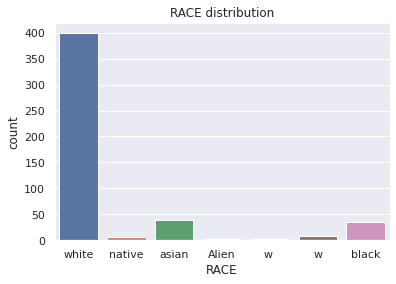

In [38]:
sns.countplot(x='RACE', data=df)
plt.title('RACE distribution')
plt.show()

##Konstrukt 2B: Besteht ein Zusammenhang zwischen Datenpunkten?

###Beispiel: Todesdatum muss NACH dem Beginn der Behandlung liegen 

In [39]:
#print(df.dtypes)

###Überführung der Objekte in den DATE Spalten in Python datetime Objekte64

In [40]:
#Überführung der Objekte in den DATE Spalten in Python datetime Objekte64
df["BIRTHDATE"] = pd.to_datetime(df["BIRTHDATE"])
df["DEATHDATE"] = pd.to_datetime(df["DEATHDATE"])
df["MED_START"] = pd.to_datetime(df["MED_START"])

In [41]:
#df["OBS_DATE"] = pd.to_datetime(df["OBS_DATE"])
#df["CON_START"] = pd.to_datetime(df["CON_START"])
#df["CON_STOP"] = pd.to_datetime(df["CON_STOP"])
#df["MED_STOP"] = pd.to_datetime(df["MED_STOP"])

In [42]:
print(df.dtypes)

BIRTHDATE                datetime64[ns]
DEATHDATE                datetime64[ns]
MARITAL                          object
RACE                             object
GENDER                           object
BIRTHPLACE                       object
OBS_DATE                         object
OBS_CODE                         object
OBS_DESCRIPTION                  object
OBS_VALUE                        object
OBS_UNITS                        object
CON_START                        object
CON_STOP                         object
CON_CODE                         object
CON_DESCRIPTION                  object
MED_START                datetime64[ns]
MED_STOP                         object
MED_CODE                        float64
MED_DESCRIPTION                  object
MED_DISPENSES                   float64
MED_REASONCODE                  float64
MED_REASONDESCRIPTION            object
dtype: object


###Identifikation der verstorbenen Patienten

In [43]:
deceased_patients = df[df.DEATHDATE.notna()]

In [44]:
deceased_patients

,BIRTHDATE,DEATHDATE,MARITAL,RACE,GENDER,BIRTHPLACE,OBS_DATE,OBS_CODE,OBS_DESCRIPTION,OBS_VALUE,OBS_UNITS,CON_START,CON_STOP,CON_CODE,CON_DESCRIPTION,MED_START,MED_STOP,MED_CODE,MED_DESCRIPTION,MED_DISPENSES,MED_REASONCODE,MED_REASONDESCRIPTION
11,1970-06-13,2016-07-05,S,white,F,Santiago Santiago Province CL,30.01.2020,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,4.0,{score},20.03.2019,10.04.2019,444814009,Viral sinusitis (disorder),2017-03-10,09.10.2018,999967.0,amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG ...,12.0,59621000.0,Hypertension
42,1959-06-17,2020-11-03,M,w,M,Worcester Massachusetts US,08.07.2019,8302-2,Body Height,94.2,cm,01.05.2019,NaN,19169002,Miscarriage in first trimester,2016-10-12,16.12.2017,310798.0,Hydrochlorothiazide 25 MG Oral Tablet,12.0,59621000.0,Hypertension
62,1940-03-05,2010-04-20,M,white,F,Hopedale Massachusetts US,06.01.2020,8480-6,Systolic Blood Pressure,112.0,mm[Hg],03.11.2016,17.11.2016,10509002,Acute bronchitis (disorder),2012-01-25,30.01.2013,429503.0,Hydrochlorothiazide 12.5 MG,12.0,59621000.0,Hypertension
72,1940-09-01,2020-03-15,M,white,M,Chelsea Massachusetts US,13.03.2020,29463-7,Body Weight,15. Aug,kg,15.05.2017,22.05.2017,444814009,Viral sinusitis (disorder),2019-06-03,11.03.2020,429503.0,Hydrochlorothiazide 12.5 MG,12.0,59621000.0,Hypertension
80,1964-06-09,1999-08-29,M,white,M,Arlington Massachusetts US,13.03.2020,92134-6,Human metapneumovirus RNA [Presence] in Respir...,Negative (qualifier value),NaN,27.06.2010,18.07.2010,44465007,Sprain of ankle,2017-10-13,20.10.2017,309362.0,Clopidogrel 75 MG Oral Tablet,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,1939-07-20,1990-06-12,M,white,M,Boston Massachusetts US,23.02.2020,2951-2,Sodium [Moles/volume] in Serum or Plasma,141.7,mmol/L,04.02.1958,NaN,59621000,Hypertension,2020-03-26,09.04.2020,313782.0,Acetaminophen 325 MG Oral Tablet,1.0,10509002.0,Acute bronchitis (disorder)
470,1913-06-27,2020-12-03,M,black,M,Boston Massachusetts US,23.02.2020,1975-2,Bilirubin.total [Mass/volume] in Serum or Plasma,14.0,mg/dL,25.12.2014,08.01.2015,44465007,Sprain of ankle,1998-04-22,12.08.1998,429503.0,Hydrochlorothiazide 12.5 MG,3.0,59621000.0,Hypertension
492,1955-02-04,2019-05-14,M,white,M,Revere Massachusetts US,24.02.2020,718-7,Hemoglobin [Mass/volume] in Blood,12. Mrz,g/dL,21.03.1967,NaN,74400008,Appendicitis,2018-05-12,11.12.2019,429503.0,Hydrochlorothiazide 12.5 MG,12.0,59621000.0,Hypertension
493,1935-11-09,1997-05-04,S,white,M,Lynn Massachusetts US,24.02.2020,4544-3,Hematocrit [Volume Fraction] of Blood by Autom...,45.7,%,21.03.1967,NaN,428251008,History of appendectomy,2019-11-12,NaN,429503.0,Hydrochlorothiazide 12.5 MG,5.0,59621000.0,Hypertension


70 Patienten sind verstorben.

### Differenz zwischen DEATHDATE und MED_START

In [45]:
pd.options.mode.chained_assignment = None  # default='warn'

Die Differenz zwischen den beiden Daten wurde berechnent. Positive Werte geben an, dass die Medikation NACH dem Sterbedatum angesetzt wurde:

In [46]:
deceased_patients['Val_Diff'] = deceased_patients['MED_START'] - deceased_patients['DEATHDATE'] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
#Transformation der Val_Diff werte in Tage
deceased_patients['time_diff_days'] = deceased_patients["Val_Diff"].dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [48]:
deceased_patients_true = deceased_patients.loc[deceased_patients['time_diff_days'] < 0]

In [49]:
deceased_patients_true.head

<bound method NDFrame.head of      BIRTHDATE  DEATHDATE  ...    Val_Diff time_diff_days
42  1959-06-17 2020-11-03  ...  -1483 days          -1483
72  1940-09-01 2020-03-15  ...   -286 days           -286
93  1940-09-01 2020-03-19  ...   -158 days           -158
107 1973-01-21 2007-09-23  ...   -663 days           -663
111 1940-09-01 2015-01-27  ...  -2633 days          -2633
115 1959-03-01 2020-03-15  ...  -3736 days          -3736
123 1940-09-01 2020-02-20  ...  -2394 days          -2394
169 1950-04-13 2001-11-12  ...  -7052 days          -7052
178 1972-12-23 2001-12-19  ...  -5269 days          -5269
180 1950-04-13 2006-06-05  ...  -6478 days          -6478
256 1923-12-06 1988-04-01  ...  -4815 days          -4815
259 1927-05-22 2014-03-22  ... -13504 days         -13504
264 1923-07-20 2002-03-15  ...  -8459 days          -8459
270 1974-01-06 2011-06-25  ... -10735 days         -10735
273 1927-05-22 2008-09-12  ...  -8977 days          -8977
279 1923-07-20 1995-07-21  ...  -3433 days

Verstorbene Patienten, die Medikation nach Todesdatum erhalten haben:

In [50]:
deceased_patients_false = deceased_patients.loc[deceased_patients['time_diff_days'] > 0]

In [51]:
deceased_patients_false

,BIRTHDATE,DEATHDATE,MARITAL,RACE,GENDER,BIRTHPLACE,OBS_DATE,OBS_CODE,OBS_DESCRIPTION,OBS_VALUE,OBS_UNITS,CON_START,CON_STOP,CON_CODE,CON_DESCRIPTION,MED_START,MED_STOP,MED_CODE,MED_DESCRIPTION,MED_DISPENSES,MED_REASONCODE,MED_REASONDESCRIPTION,Val_Diff,time_diff_days
11,1970-06-13,2016-07-05,S,white,F,Santiago Santiago Province CL,30.01.2020,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,4.0,{score},20.03.2019,10.04.2019,444814009,Viral sinusitis (disorder),2017-03-10,09.10.2018,999967.0,amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG ...,12.0,59621000.0,Hypertension,248 days,248
62,1940-03-05,2010-04-20,M,white,F,Hopedale Massachusetts US,06.01.2020,8480-6,Systolic Blood Pressure,112.0,mm[Hg],03.11.2016,17.11.2016,10509002,Acute bronchitis (disorder),2012-01-25,30.01.2013,429503.0,Hydrochlorothiazide 12.5 MG,12.0,59621000.0,Hypertension,645 days,645
80,1964-06-09,1999-08-29,M,white,M,Arlington Massachusetts US,13.03.2020,92134-6,Human metapneumovirus RNA [Presence] in Respir...,Negative (qualifier value),NaN,27.06.2010,18.07.2010,44465007,Sprain of ankle,2017-10-13,20.10.2017,309362.0,Clopidogrel 75 MG Oral Tablet,1.0,NaN,NaN,6620 days,6620
83,1946-09-09,2009-03-04,M,white,M,Stow Massachusetts US,28.04.2020,8310-5,Body temperature,37.6,Cel,10.11.2012,22.11.2012,195662009,Acute viral pharyngitis (disorder),2017-10-13,20.10.2017,197361.0,Amlodipine 5 MG Oral Tablet,1.0,NaN,NaN,3145 days,3145
89,1964-06-09,2014-09-10,M,white,M,Waltham Massachusetts US,15.10.2019,29463-7,Body Weight,68.2,kg,02.01.2007,NaN,162864005,Body mass index 30+ - obesity (finding),2018-10-26,01.11.2019,309362.0,Clopidogrel 75 MG Oral Tablet,12.0,NaN,NaN,1507 days,1507
143,1964-12-23,1997-07-05,M,white,F,North Reading Massachusetts US,01.03.2020,29463-7,Body Weight,45.3,kg,04.04.2006,NaN,162864005,Body mass index 30+ - obesity (finding),2019-12-02,18.02.2020,895994.0,120 ACTUAT Fluticasone propionate 0.044 MG/ACT...,12.0,233678006.0,Childhood asthma,8185 days,8185
172,1923-07-20,1934-10-08,NaN,white,M,West Springfield Massachusetts US,15.11.2019,QOLS,QOLS,1.0,{score},29.12.2014,19.01.2015,444814009,Viral sinusitis (disorder),1983-12-08,12.08.1983,310798.0,Hydrochlorothiazide 25 MG Oral Tablet,1.0,59621000.0,Hypertension,17958 days,17958
183,1923-07-20,1983-01-16,M,white,M,Cohasset Massachusetts US,12.06.2019,789-8,Erythrocytes [#/volume] in Blood by Automated ...,04. Jan,10*6/uL,06.10.2003,NaN,239872002,Osteoarthritis of hip,1991-09-27,02.10.1992,310798.0,Hydrochlorothiazide 25 MG Oral Tablet,12.0,59621000.0,Hypertension,3176 days,3176
201,1994-05-31,1999-11-20,NaN,white,F,Boston Massachusetts US,17.07.2019,8867-4,Heart rate,98.0,/min,24.11.2004,NaN,271737000,Anemia (disorder),2009-02-01,08.01.2010,310798.0,Hydrochlorothiazide 25 MG Oral Tablet,12.0,59621000.0,Hypertension,3361 days,3361
204,1923-07-20,2004-07-27,S,white,M,Barnstable Massachusetts US,18.09.2019,8302-2,Body Height,58.6,cm,09.11.2011,23.11.2011,35999006,Blighted ovum,2012-01-20,25.01.2013,310798.0,Hydrochlorothiazide 25 MG Oral Tablet,12.0,59621000.0,Hypertension,2733 days,2733


In [52]:
#Index der betroffen Zeilen

In [53]:
deceased_patients_false.index.values

array([ 11,  62,  80,  83,  89, 143, 172, 183, 201, 204, 205, 217, 235,
       246, 253, 297, 306, 312, 315, 318, 330, 341, 347, 355, 356, 368,
       395, 399, 402, 408, 411, 414, 416, 420, 438, 439, 463, 493])

Diese Datenpunkte sind sehr wahrscheinlich fehlerhaft und werden weiter unten bereinigt.

###Schwangere mit dem Geschlecht M(ale)

Identifikaion aller Zeilen mit dem Eintrag 'Normal pregnancy' in der Spalte CON_DESCRIPTION

In [54]:
pregnant_patients = df.loc[(df['CON_DESCRIPTION'] == 'Normal pregnancy')]
pregnant_patients.count

<bound method DataFrame.count of      BIRTHDATE  DEATHDATE  ... MED_REASONCODE MED_REASONDESCRIPTION
27  1993-06-04        NaT  ...     59621000.0          Hypertension
33  1965-11-11        NaT  ...     59621000.0          Hypertension
35  1967-12-07        NaT  ...     59621000.0          Hypertension
37  2013-07-30        NaT  ...     59621000.0          Hypertension
39  2002-01-24        NaT  ...     59621000.0          Hypertension
41  1979-06-13        NaT  ...     59621000.0          Hypertension
46  1982-06-19        NaT  ...     59621000.0          Hypertension
49  1978-11-27        NaT  ...            NaN                   NaN
50  1998-11-01        NaT  ...            NaN                   NaN
51  1976-03-20        NaT  ...     59621000.0          Hypertension
53  1955-03-05        NaT  ...     59621000.0          Hypertension
55  2020-12-03        NaT  ...     59621000.0          Hypertension
57  1995-02-10        NaT  ...     59621000.0          Hypertension
104 1955-08-20 

50 Zeileneinträge weisen diesen Merkmal auf.

Aufteilung in Geschlecht 

In [55]:
pregnant_males = df.loc[(df['CON_DESCRIPTION'] == 'Normal pregnancy') & (df['GENDER'] == 'M')]
pregnant_females = df.loc[(df['CON_DESCRIPTION'] == 'Normal pregnancy') & (df['GENDER'] == 'F')]

Darstellung

In [56]:
sns.set(rc={'figure.figsize':(7,5)})

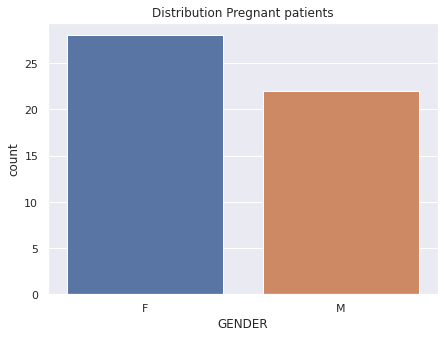

In [57]:
sns.countplot(x='GENDER', data=pregnant_patients)
plt.title('Distribution Pregnant patients')
plt.show()

#3. Verbesserungsvorschläge

##Die Einträge in der Spalte RACE mit den Merkmalen *Alien* oder *w* wurden entfernt.

In [58]:
#Identifkation der Aliens
df_Aliens = df.loc[(df['RACE'] == 'Alien')]

In [59]:
#Indizierung
df_Aliens.index.values

array([ 38, 159, 456])

In [60]:
#Bereinigung
df_cleaned = df.drop(labels=[38, 159, 456], axis=0)

In [61]:
#Identifkation der Einträge w
df_w = df_cleaned.loc[(df['RACE'] == 'w')]

In [62]:
#Indizierung
df_w.index.values

array([45, 46, 47, 48, 49, 50, 51, 52, 53])

###Interesanterweise werden nicht alle Indices mit dem Merkmal w agezeigt. Die Indices 42-44 wurden manuell hinzugefügt:

In [63]:
#Bereinigung
df_cleaned_2 = df_cleaned.drop(labels=[42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53], axis=0)

##Entfernung der schwangeren männlichen Patienten

In [64]:
#Identifikation
df_pregnant_m = df_cleaned_2.loc[(df_cleaned_2['CON_DESCRIPTION'] == 'Normal pregnancy') & (df_cleaned_2['GENDER'] == 'M')]

In [65]:
#Indexierung
df_pregnant_m.index.values

array([ 35,  41,  57, 140, 144, 145, 194, 202, 236, 277, 278, 279, 284,
       287, 312, 406, 412, 413, 440])

In [66]:
#Entfernung der schwangeren männlichen Patienten
df_no_pregnat_m = df_cleaned_2.drop(labels=[35,  41,  57, 140, 144, 145, 194, 202, 236, 277, 278, 279, 284,
       287, 312, 406, 412, 413, 440], axis=0)

##Entfernung der nicht aktuell verstorbenen Patienten sowie der Patienten, mit Medikation nach Todesdatum und fehlerhaften Einträgen in der Spalte OBS_Date

In [67]:
#Identifikation laut Index aus Abschnitt Datenaufbereitung, 2B
df_incorrect_deathdate = df_no_pregnat_m.drop(labels=[11,  62,  80,  83,  89, 143, 172, 183, 201, 204, 205, 217, 235,
       246, 253, 297, 306, 315, 318, 330, 341, 347, 355, 356, 368,
       395, 399, 402, 408, 411, 414, 416, 420, 438, 439, 463, 493], axis=0)

In [68]:
#Welche Patienten sind vor 2019 gestorben?
df_old_deathdate = df_incorrect_deathdate.loc[df_incorrect_deathdate['DEATHDATE'] < '2019-01-01']

In [69]:
df_old_deathdate.count 

<bound method DataFrame.count of      BIRTHDATE  DEATHDATE  ... MED_REASONCODE MED_REASONDESCRIPTION
107 1973-01-21 2007-09-23  ...    233678006.0      Childhood asthma
111 1940-09-01 2015-01-27  ...    233678006.0      Childhood asthma
169 1950-04-13 2001-11-12  ...     59621000.0          Hypertension
178 1972-12-23 2001-12-19  ...     59621000.0          Hypertension
180 1950-04-13 2006-06-05  ...     59621000.0          Hypertension
256 1923-12-06 1988-04-01  ...    233678006.0      Childhood asthma
259 1927-05-22 2014-03-22  ...    233678006.0      Childhood asthma
264 1923-07-20 2002-03-15  ...    233678006.0      Childhood asthma
270 1974-01-06 2011-06-25  ...    233678006.0      Childhood asthma
273 1927-05-22 2008-09-12  ...    233678006.0      Childhood asthma
291 1927-05-22 1996-12-22  ...    233678006.0      Childhood asthma
308 1980-03-13 2017-07-04  ...    233678006.0      Childhood asthma
319 1959-02-16 2018-09-24  ...    233678006.0      Childhood asthma
387 1969-04-11 

19 Patienten wuden ausgeschlossen, da sie vor 2019 verstorben waren

In [70]:
df_old_deathdate.index.values

array([107, 111, 169, 178, 180, 256, 259, 264, 270, 273, 291, 308, 319,
       387, 392, 428, 447, 462, 494])

In [71]:
df_clean_final = df_incorrect_deathdate.drop(labels=[107, 111, 169, 178, 180, 256, 259, 264, 270, 273, 291, 308, 319,
       387, 392, 428, 447, 462], axis=0)

In [72]:
#Löschen von Spalten mit fehlerhaften Eintrag in OBS_date

In [73]:
df_clean_date = df_clean_final.loc[df_clean_final['OBS_DATE'] == "4386200%"]

In [74]:
df_clean_date2 = df_clean_final.loc[df_clean_final['OBS_DATE'] == "4386300%"]

In [75]:
df_clean_date2

,BIRTHDATE,DEATHDATE,MARITAL,RACE,GENDER,BIRTHPLACE,OBS_DATE,OBS_CODE,OBS_DESCRIPTION,OBS_VALUE,OBS_UNITS,CON_START,CON_STOP,CON_CODE,CON_DESCRIPTION,MED_START,MED_STOP,MED_CODE,MED_DESCRIPTION,MED_DISPENSES,MED_REASONCODE,MED_REASONDESCRIPTION
14,1983-09-30,NaT,M,white,F,Agawam Massachusetts US,4386300%,9843-4,Head Occipital-frontal circumference,47.4,cm,23.04.2019,07.05.2019,10509002,Acute bronchitis (disorder),2019-12-26,NaN,757594.0,Jolivette 28 Day Pack,5.0,NaN,NaN


In [76]:
#Löschen der 13. und 14. Zeile

In [77]:
df_clean_final_v2 = df_clean_final.drop(labels=[13, 14], axis=0)

Finaler Dataframe für Version 2

In [78]:
df_clean_final_v2 

,BIRTHDATE,DEATHDATE,MARITAL,RACE,GENDER,BIRTHPLACE,OBS_DATE,OBS_CODE,OBS_DESCRIPTION,OBS_VALUE,OBS_UNITS,CON_START,CON_STOP,CON_CODE,CON_DESCRIPTION,MED_START,MED_STOP,MED_CODE,MED_DESCRIPTION,MED_DISPENSES,MED_REASONCODE,MED_REASONDESCRIPTION
0,2017-08-24,NaT,NaN,white,M,Beverly Massachusetts US,01.08.2019,8302-2,Body Height,82.7,cm,01.05.2001,NaN,40055000,Chronic sinusitis (disorder),2019-10-30,13.11.2019,308182.0,Amoxicillin 250 MG Oral Capsule,1.0,NaN,NaN
1,2016-01-08,NaT,NaN,white,F,Boston Massachusetts US,01.08.2019,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,2.0,{score},09.08.2011,16.08.2011,444814009,Viral sinusitis (disorder),2019-10-30,13.11.2019,313820.0,Acetaminophen 160 MG Chewable Tablet,1.0,NaN,NaN
2,1992-06-30,NaT,S,white,M,Springfield Massachusetts US,01.08.2019,29463-7,Body Weight,12. Jun,kg,16.11.2011,26.11.2011,195662009,Acute viral pharyngitis (disorder),2020-12-02,26.02.2020,313820.0,Acetaminophen 160 MG Chewable Tablet,1.0,NaN,NaN
3,2004-09-01,NaT,NaN,white,F,Worcester Massachusetts US,01.08.2019,77606-2,Weight-for-length Per age and sex,86.1,%,13.05.2011,27.05.2011,10509002,Acute bronchitis (disorder),2020-04-28,08.05.2020,834061.0,Penicillin V Potassium 250 MG Oral Tablet,1.0,43878008.0,Streptococcal sore throat (disorder)
4,1996-11-15,NaT,NaN,white,M,Patras Achaea GR,01.08.2019,9843-4,Head Occipital-frontal circumference,46.9,cm,06.02.2011,14.02.2011,195662009,Acute viral pharyngitis (disorder),2010-11-22,30.08.2011,999967.0,amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG ...,9.0,59621000.0,Hypertension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1955-02-04,2019-05-14,M,white,M,Revere Massachusetts US,24.02.2020,718-7,Hemoglobin [Mass/volume] in Blood,12. Mrz,g/dL,21.03.1967,NaN,74400008,Appendicitis,2018-05-12,11.12.2019,429503.0,Hydrochlorothiazide 12.5 MG,12.0,59621000.0,Hypertension
494,1913-06-27,1996-03-25,M,black,M,Millis Massachusetts US,24.02.2020,787-2,MCV [Entitic volume] by Automated count,89.3,fL,12.06.1977,NaN,370143000,Major depression disorder,1977-09-09,16.08.1978,746030.0,Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet,11.0,59621000.0,Hypertension
495,1986-03-29,NaT,M,white,M,Haverhill Massachusetts US,24.02.2020,785-6,MCH [Entitic mass] by Automated count,29. Mai,pg,29.06.1980,NaN,7200002,Alcoholism,1978-08-16,22.08.1979,746030.0,Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet,12.0,59621000.0,Hypertension
496,1954-12-11,NaT,M,white,F,Attleboro Massachusetts US,24.02.2020,786-4,MCHC [Mass/volume] by Automated count,32.4,g/dL,29.06.1980,NaN,15777000,Prediabetes,1979-08-22,27.08.1980,746030.0,Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet,12.0,59621000.0,Hypertension


In [79]:
df_clean_final_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 0 to 497
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   BIRTHDATE              404 non-null    datetime64[ns]
 1   DEATHDATE              12 non-null     datetime64[ns]
 2   MARITAL                263 non-null    object        
 3   RACE                   404 non-null    object        
 4   GENDER                 404 non-null    object        
 5   BIRTHPLACE             404 non-null    object        
 6   OBS_DATE               404 non-null    object        
 7   OBS_CODE               404 non-null    object        
 8   OBS_DESCRIPTION        404 non-null    object        
 9   OBS_VALUE              404 non-null    object        
 10  OBS_UNITS              349 non-null    object        
 11  CON_START              404 non-null    object        
 12  CON_STOP               252 non-null    object        
 13  CON_C

In [80]:
df_clean_final_v2.loc[1]

BIRTHDATE                                              2016-01-08 00:00:00
DEATHDATE                                                              NaT
MARITAL                                                                NaN
RACE                                                                 white
GENDER                                                                   F
BIRTHPLACE                                       Boston  Massachusetts  US
OBS_DATE                                                        01.08.2019
OBS_CODE                                                           72514-3
OBS_DESCRIPTION          Pain severity - 0-10 verbal numeric rating [Sc...
OBS_VALUE                                                              2.0
OBS_UNITS                                                          {score}
CON_START                                                       09.08.2011
CON_STOP                                                        16.08.2011
CON_CODE                 

In [81]:
df_clean_final_v2.describe

<bound method NDFrame.describe of      BIRTHDATE  DEATHDATE  ... MED_REASONCODE                 MED_REASONDESCRIPTION
0   2017-08-24        NaT  ...            NaN                                   NaN
1   2016-01-08        NaT  ...            NaN                                   NaN
2   1992-06-30        NaT  ...            NaN                                   NaN
3   2004-09-01        NaT  ...     43878008.0  Streptococcal sore throat (disorder)
4   1996-11-15        NaT  ...     59621000.0                          Hypertension
..         ...        ...  ...            ...                                   ...
492 1955-02-04 2019-05-14  ...     59621000.0                          Hypertension
494 1913-06-27 1996-03-25  ...     59621000.0                          Hypertension
495 1986-03-29        NaT  ...     59621000.0                          Hypertension
496 1954-12-11        NaT  ...     59621000.0                          Hypertension
497 1943-03-21        NaT  ...     5962100

##Erstellung Version 2

In [82]:
#df_clean_final_v2.to_csv(r'/content/drive/MyDrive/Forschungsdatenmanagement/Hausarbeit/csv_files/Kopie_Complete_Dataset_Covid_10k_Valid_V2.csv', index = False)

#4. Metadaten

In [83]:
#Überführung der anderen Daten in das ISO 8601 Format mittels pd.to_datetime

In [84]:
df = df_clean_final_v2

In [85]:
df["OBS_DATE"] = pd.to_datetime(df["OBS_DATE"])
df["MED_STOP"] = pd.to_datetime(df["MED_STOP"])

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 0 to 497
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   BIRTHDATE              404 non-null    datetime64[ns]
 1   DEATHDATE              12 non-null     datetime64[ns]
 2   MARITAL                263 non-null    object        
 3   RACE                   404 non-null    object        
 4   GENDER                 404 non-null    object        
 5   BIRTHPLACE             404 non-null    object        
 6   OBS_DATE               404 non-null    datetime64[ns]
 7   OBS_CODE               404 non-null    object        
 8   OBS_DESCRIPTION        404 non-null    object        
 9   OBS_VALUE              404 non-null    object        
 10  OBS_UNITS              349 non-null    object        
 11  CON_START              404 non-null    object        
 12  CON_STOP               252 non-null    object        
 13  CON_C

In [87]:
df.loc[1]

BIRTHDATE                                              2016-01-08 00:00:00
DEATHDATE                                                              NaT
MARITAL                                                                NaN
RACE                                                                 white
GENDER                                                                   F
BIRTHPLACE                                       Boston  Massachusetts  US
OBS_DATE                                               2019-01-08 00:00:00
OBS_CODE                                                           72514-3
OBS_DESCRIPTION          Pain severity - 0-10 verbal numeric rating [Sc...
OBS_VALUE                                                              2.0
OBS_UNITS                                                          {score}
CON_START                                                       09.08.2011
CON_STOP                                                        16.08.2011
CON_CODE                 

##Erstellung Version 3

In [88]:
#df.to_csv(r'/content/drive/MyDrive/Forschungsdatenmanagement/Hausarbeit/csv_files/Kopie_Complete_Dataset_Covid_10k_Valid_V3.csv', index = False)

#Data Cleaning

## Fehlende Werte/Nullwerte Identifizieren



### Heatmap 

Mithilfe des Tools Seaborn können leere Zeilen im Dataframe erkannt werden.

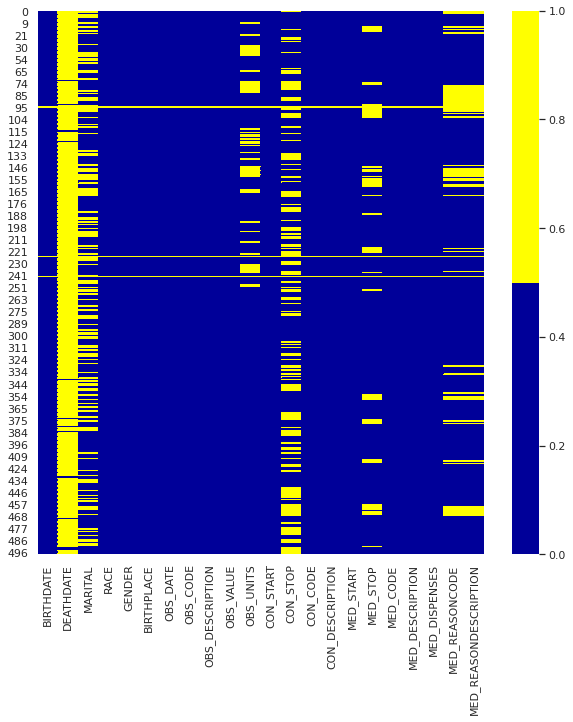

In [89]:
cols = df.columns
colours = ['#000099', '#ffff00'] # yellow is missing. blue is not missing.
#Erstellung einer Heatmap
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

**Interpretation:**
1.   komplett leere Zeilen im Bereich um 95, 220 und 241 identifiziert.
2.   Einige Variabeln wie DEATHDATE, OBS_UNIT und CON_STOP haben relativ viele leere Zeilen.




### Fehlende Werte in %

Mittels eines for loops können die fehlenden Werte quantifiziert werden:

In [90]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

BIRTHDATE - 1%
DEATHDATE - 97%
MARITAL - 35%
RACE - 1%
GENDER - 1%
BIRTHPLACE - 1%
OBS_DATE - 1%
OBS_CODE - 1%
OBS_DESCRIPTION - 1%
OBS_VALUE - 1%
OBS_UNITS - 14%
CON_START - 1%
CON_STOP - 38%
CON_CODE - 1%
CON_DESCRIPTION - 1%
MED_START - 1%
MED_STOP - 14%
MED_CODE - 1%
MED_DESCRIPTION - 1%
MED_DISPENSES - 1%
MED_REASONCODE - 16%
MED_REASONDESCRIPTION - 16%


###Lösungsvorschlag: Leere Zeilen löschen

In [91]:
#Kompletter DF zeigen
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#df

In [92]:
#Zeilen identifizieren, in denen das Geburstdatum = 0 ist.
df['BIRTHDATE'].isnull().sum()

3

In [93]:
#Zeilen identifizieren, in denen das Geburstdatum = 0 ist.
index = df.loc[pd.isna(df["BIRTHDATE"]), :].index
index

Int64Index([95, 225, 242], dtype='int64')

In [94]:
#Indizierte Zeilen aus dem Dataframe löschen
df = df.drop(index)

In [95]:
df.shape

(404, 22)

3 Zeilen wurden aus dem Dataframe gelöscht.


## Duplikate

Duplizierte Reihen indentifizieren anhand von 5 Spalten

In [96]:
#Definition der Spalten
column_names = ['BIRTHDATE', 'DEATHDATE', 'MARITAL', 'GENDER', 'BIRTHPLACE']

In [97]:
#Identifikation der duplizierten Zeilen
duplicates = df.duplicated(subset = column_names, keep=False)
df[duplicates]

,BIRTHDATE,DEATHDATE,MARITAL,RACE,GENDER,BIRTHPLACE,OBS_DATE,OBS_CODE,OBS_DESCRIPTION,OBS_VALUE,OBS_UNITS,CON_START,CON_STOP,CON_CODE,CON_DESCRIPTION,MED_START,MED_STOP,MED_CODE,MED_DESCRIPTION,MED_DISPENSES,MED_REASONCODE,MED_REASONDESCRIPTION
23,1986-02-25,NaT,M,native,F,Lynn Massachusetts US,2020-01-03,9279-1,Respiratory rate,32.9,/min,31.07.2004,NaN,162864005,Body mass index 30+ - obesity (finding),1998-08-29,1999-04-09,310798.0,Hydrochlorothiazide 25 MG Oral Tablet,12.0,59621000.0,Hypertension
24,1986-02-25,NaT,M,native,F,Lynn Massachusetts US,2020-01-03,9279-1,Respiratory rate,32.9,/min,31.07.2004,NaN,162864005,Body mass index 30+ - obesity (finding),1998-08-29,1999-04-09,310798.0,Hydrochlorothiazide 25 MG Oral Tablet,12.0,59621000.0,Hypertension
124,1959-03-01,NaT,M,white,M,Medford Massachusetts US,2020-11-03,94040-3,Adenovirus A+B+C+D+E DNA [Presence] in Respira...,Negative (qualifier value),NaN,29.06.2014,13.07.2014,444814009,Viral sinusitis (disorder),2013-08-01,2013-09-07,895994.0,120 ACTUAT Fluticasone propionate 0.044 MG/ACT...,6.0,233678006.0,Childhood asthma
131,1959-03-01,NaT,M,white,M,Medford Massachusetts US,2020-11-03,94040-3,Adenovirus A+B+C+D+E DNA [Presence] in Respira...,Negative (qualifier value),NaN,29.06.2014,13.07.2014,444814009,Viral sinusitis (disorder),2013-08-01,2013-09-07,895994.0,120 ACTUAT Fluticasone propionate 0.044 MG/ACT...,6.0,233678006.0,Childhood asthma


In [98]:
#Löschen der zwei doppelten Zeilen
df = df.drop(labels=[23, 124], axis=0)

In [99]:
#Anzeigen der neuen Zeilen-Zahl
df.shape

(402, 22)

2 Zeilen wurden aus dem Dataframe gelöscht.

## Datenformat

Zuerst sollte sich ein Überblick über die verschiedenen Datentypen verschafft werden. Dies kann mit Hilfe der .info Funktion durchgeführt werden.

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 0 to 497
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   BIRTHDATE              402 non-null    datetime64[ns]
 1   DEATHDATE              12 non-null     datetime64[ns]
 2   MARITAL                261 non-null    object        
 3   RACE                   402 non-null    object        
 4   GENDER                 402 non-null    object        
 5   BIRTHPLACE             402 non-null    object        
 6   OBS_DATE               402 non-null    datetime64[ns]
 7   OBS_CODE               402 non-null    object        
 8   OBS_DESCRIPTION        402 non-null    object        
 9   OBS_VALUE              402 non-null    object        
 10  OBS_UNITS              348 non-null    object        
 11  CON_START              402 non-null    object        
 12  CON_STOP               251 non-null    object        
 13  CON_C

###Kategotische Werte

Die Spalten mit kategorischen Werten können über eine Funktion identifiziert werden. Dafür lässt man sich die Anzahl der Merkmalsausprägungen anzeigen.

In [101]:
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
2,MARITAL,2
4,GENDER,2
3,RACE,4
1,DEATHDATE,10
21,MED_REASONDESCRIPTION,11
20,MED_REASONCODE,11
19,MED_DISPENSES,24
10,OBS_UNITS,25
6,OBS_DATE,26
17,MED_CODE,38


Die Spalten **MARITAL**, **RACE** und **GENDER** enthalten kategorische (<10 Merkmale) Werte und können transformiert werden.

In [102]:
cols_to_exclude = ['DEATHDATE	', 'OBS_DATE	', 'BIRTHDATE', 'CON_STOP', 'CON_START']
for col in df.columns:
    if df[col].nunique() < 10 and col not in cols_to_exclude:
        df[col] = df[col].astype('category')

Der neue Dataframe ist kleiner und enthält nun die kategorischen Werte und ist kleiner.

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 0 to 497
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   BIRTHDATE              402 non-null    datetime64[ns]
 1   DEATHDATE              12 non-null     datetime64[ns]
 2   MARITAL                261 non-null    category      
 3   RACE                   402 non-null    category      
 4   GENDER                 402 non-null    category      
 5   BIRTHPLACE             402 non-null    object        
 6   OBS_DATE               402 non-null    datetime64[ns]
 7   OBS_CODE               402 non-null    object        
 8   OBS_DESCRIPTION        402 non-null    object        
 9   OBS_VALUE              402 non-null    object        
 10  OBS_UNITS              348 non-null    object        
 11  CON_START              402 non-null    object        
 12  CON_STOP               251 non-null    object        
 13  CON_C

###Schreibweise BIRTHPLACE

Das Format des Geburtsortes beachtet Groß- und Kleinschreibung. Dies ist potentiell problematisch für die  Maschinenlesbarkeit, v.a. von Python-basierten Applikatonen.
Außerdem fallen einige irreguläre Werte mit Sonderzeichen auf.

Das Ziel ist es, dass irreguläre Werte in der Spalte BIRTHPLACE  entfernt und eine einheitliche Schreibweise eingeführt werden(Klein-Schreibung und Entfernung von Leerzeichen)

In [104]:
df['BIRTHPLACE']

0          Beverly  Massachusetts  US
1           Boston  Massachusetts  US
2      Springfield  Massachusetts  US
3        Worcester  Massachusetts  US
4                  Patras  Achaea  GR
                    ...              
492         Revere  Massachusetts  US
494         Millis  Massachusetts  US
495      Haverhill  Massachusetts  US
496      Attleboro  Massachusetts  US
497        Amherst  Massachusetts  US
Name: BIRTHPLACE, Length: 402, dtype: object

In [105]:
df['BIRTHPLACE_new'] = df['BIRTHPLACE'].str.lower()
df['BIRTHPLACE_new'] = df['BIRTHPLACE_new'].str.strip() # remove leading and trailing whitespace.
df['BIRTHPLACE_new'] = df['BIRTHPLACE_new'].str.replace('\\.', '') # remove period.
df

,BIRTHDATE,DEATHDATE,MARITAL,RACE,GENDER,BIRTHPLACE,OBS_DATE,OBS_CODE,OBS_DESCRIPTION,OBS_VALUE,OBS_UNITS,CON_START,CON_STOP,CON_CODE,CON_DESCRIPTION,MED_START,MED_STOP,MED_CODE,MED_DESCRIPTION,MED_DISPENSES,MED_REASONCODE,MED_REASONDESCRIPTION,BIRTHPLACE_new
0,2017-08-24,NaT,NaN,white,M,Beverly Massachusetts US,2019-01-08,8302-2,Body Height,82.7,cm,01.05.2001,NaN,40055000,Chronic sinusitis (disorder),2019-10-30,2019-11-13,308182.0,Amoxicillin 250 MG Oral Capsule,1.0,NaN,NaN,beverly massachusetts us
1,2016-01-08,NaT,NaN,white,F,Boston Massachusetts US,2019-01-08,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,2.0,{score},09.08.2011,16.08.2011,444814009,Viral sinusitis (disorder),2019-10-30,2019-11-13,313820.0,Acetaminophen 160 MG Chewable Tablet,1.0,NaN,NaN,boston massachusetts us
2,1992-06-30,NaT,S,white,M,Springfield Massachusetts US,2019-01-08,29463-7,Body Weight,12. Jun,kg,16.11.2011,26.11.2011,195662009,Acute viral pharyngitis (disorder),2020-12-02,2020-02-26,313820.0,Acetaminophen 160 MG Chewable Tablet,1.0,NaN,NaN,springfield massachusetts us
3,2004-09-01,NaT,NaN,white,F,Worcester Massachusetts US,2019-01-08,77606-2,Weight-for-length Per age and sex,86.1,%,13.05.2011,27.05.2011,10509002,Acute bronchitis (disorder),2020-04-28,2020-08-05,834061.0,Penicillin V Potassium 250 MG Oral Tablet,1.0,43878008.0,Streptococcal sore throat (disorder),worcester massachusetts us
4,1996-11-15,NaT,NaN,white,M,Patras Achaea GR,2019-01-08,9843-4,Head Occipital-frontal circumference,46.9,cm,06.02.2011,14.02.2011,195662009,Acute viral pharyngitis (disorder),2010-11-22,2011-08-30,999967.0,amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG ...,9.0,59621000.0,Hypertension,patras achaea gr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1955-02-04,2019-05-14,M,white,M,Revere Massachusetts US,2020-02-24,718-7,Hemoglobin [Mass/volume] in Blood,12. Mrz,g/dL,21.03.1967,NaN,74400008,Appendicitis,2018-05-12,2019-11-12,429503.0,Hydrochlorothiazide 12.5 MG,12.0,59621000.0,Hypertension,revere massachusetts us
494,1913-06-27,1996-03-25,M,black,M,Millis Massachusetts US,2020-02-24,787-2,MCV [Entitic volume] by Automated count,89.3,fL,12.06.1977,NaN,370143000,Major depression disorder,1977-09-09,1978-08-16,746030.0,Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet,11.0,59621000.0,Hypertension,millis massachusetts us
495,1986-03-29,NaT,M,white,M,Haverhill Massachusetts US,2020-02-24,785-6,MCH [Entitic mass] by Automated count,29. Mai,pg,29.06.1980,NaN,7200002,Alcoholism,1978-08-16,1979-08-22,746030.0,Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet,12.0,59621000.0,Hypertension,haverhill massachusetts us
496,1954-12-11,NaT,M,white,F,Attleboro Massachusetts US,2020-02-24,786-4,MCHC [Mass/volume] by Automated count,32.4,g/dL,29.06.1980,NaN,15777000,Prediabetes,1979-08-22,1980-08-27,746030.0,Atenolol 50 MG / Chlorthalidone 25 MG Oral Tablet,12.0,59621000.0,Hypertension,attleboro massachusetts us


Zeilen mit irreguläre Schreibweise entfernen

In [106]:
df_new = df.loc[df['BIRTHPLACE_new'] == 'hanoi  h√† ƒê√¥ng  vn']

In [107]:
df_new

,BIRTHDATE,DEATHDATE,MARITAL,RACE,GENDER,BIRTHPLACE,OBS_DATE,OBS_CODE,OBS_DESCRIPTION,OBS_VALUE,OBS_UNITS,CON_START,CON_STOP,CON_CODE,CON_DESCRIPTION,MED_START,MED_STOP,MED_CODE,MED_DESCRIPTION,MED_DISPENSES,MED_REASONCODE,MED_REASONDESCRIPTION,BIRTHPLACE_new
129,1971-09-10,NaT,S,asian,F,Hanoi H√† ƒê√¥ng VN,2019-06-30,QALY,QALY,26.0,a,10.03.2020,31.03.2020,444814009,Viral sinusitis (disorder),2014-01-14,2014-01-14,2123111.0,NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT ...,1.0,233678006.0,Childhood asthma,hanoi h√† ƒê√¥ng vn
288,1984-12-20,NaT,M,asian,F,Hanoi H√† ƒê√¥ng VN,2020-02-19,1975-2,Bilirubin.total [Mass/volume] in Serum or Plasma,10. Jun,mg/dL,17.10.2010,30.12.2010,65363002,Otitis media,1990-03-20,1991-03-26,2123111.0,NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT ...,12.0,233678006.0,Childhood asthma,hanoi h√† ƒê√¥ng vn


**h√† ƒê√¥ng  vn** wird zu **hanoi hanoi  vn**

In [108]:
df.loc[129, 'BIRTHPLACE'] = 'Hanoi  Hanoi  VN'
df.loc[288, 'BIRTHPLACE'] = 'Hanoi  Hanoi  VN'
df.loc[129, 'BIRTHPLACE_new'] = 'hanoi  hanoi  vn'
df.loc[288, 'BIRTHPLACE_new'] = 'hanoi  hanoi  vn'

In [109]:
df.loc[288,]

BIRTHDATE                                              1984-12-20 00:00:00
DEATHDATE                                                              NaT
MARITAL                                                                  M
RACE                                                                 asian
GENDER                                                                   F
BIRTHPLACE                                                Hanoi  Hanoi  VN
OBS_DATE                                               2020-02-19 00:00:00
OBS_CODE                                                            1975-2
OBS_DESCRIPTION           Bilirubin.total [Mass/volume] in Serum or Plasma
OBS_VALUE                                                          10. Jun
OBS_UNITS                                                            mg/dL
CON_START                                                       17.10.2010
CON_STOP                                                        30.12.2010
CON_CODE                 

###Verbleibende Daten umformatieren

In [110]:
df["CON_START"] = pd.to_datetime(df["CON_START"])
df["CON_STOP"] = pd.to_datetime(df["CON_STOP"])

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 0 to 497
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   BIRTHDATE              402 non-null    datetime64[ns]
 1   DEATHDATE              12 non-null     datetime64[ns]
 2   MARITAL                261 non-null    category      
 3   RACE                   402 non-null    category      
 4   GENDER                 402 non-null    category      
 5   BIRTHPLACE             402 non-null    object        
 6   OBS_DATE               402 non-null    datetime64[ns]
 7   OBS_CODE               402 non-null    object        
 8   OBS_DESCRIPTION        402 non-null    object        
 9   OBS_VALUE              402 non-null    object        
 10  OBS_UNITS              348 non-null    object        
 11  CON_START              402 non-null    datetime64[ns]
 12  CON_STOP               251 non-null    datetime64[ns]
 13  CON_C

## Irreguläre Daten / Extremwerte

###MED_DISPENSES Spalte

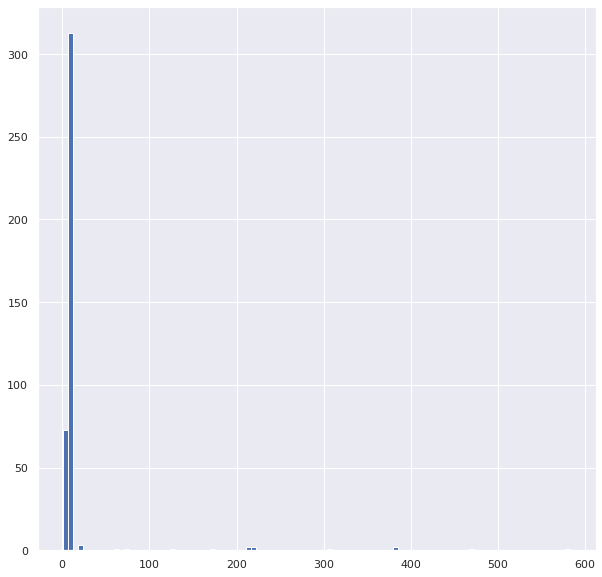

In [112]:
#Histogramm
df['MED_DISPENSES'].hist(bins=100)

In [113]:
#Deskriptive Statistik mit DataFrame.describe()
df['MED_DISPENSES'].describe()

count    402.000000
mean      18.325871
std       52.555120
min        1.000000
25%       12.000000
50%       12.000000
75%       12.000000
max      583.000000
Name: MED_DISPENSES, dtype: float64

Der höchste Wert liegt bei **583**, obwohl der Mittelwert bei 18 liegt. Sehr wahrscheinlich ein Ausreißer.

###CODE Spalten 


####CON_CODE

Die Werte für die Reihen 320, 396, 451 und 458 wurden durch die korrekten SNOMED-CT Codes ersetzt.

In [114]:
#Alle Einträge in der Spalte CON_CODE
df['CON_CODE'].sort_values(ascending=True)

320    1,24171E+14
396    1,24171E+14
458      1,551E+12
252       10509002
433       10509002
          ...     
394       82423001
346       83664006
386       84757009
488       87433001
468       92691004
Name: CON_CODE, Length: 402, dtype: object

In [115]:
df.loc[320, 'CON_CODE'] = '437931000124100' #SNOMED füe Migräne
df.loc[396, 'CON_CODE'] = '437931000124100'
df.loc[458, 'CON_CODE'] = '1551000119108' #SNOMED für Diabetische Retinopathie
df.loc[451, 'CON_CODE'] = '1511000119107' #SNOMED für periphere Neuropathie

In der Spalte wurden Objects zu Int64 (also Zahlen umgewandelt)

In [116]:
df['CON_CODE'] = pd.to_numeric(df['CON_CODE']) 

In [117]:
df['CON_CODE'].describe

<bound method NDFrame.describe of 0       40055000
1      444814009
2      195662009
3       10509002
4      195662009
         ...    
492     74400008
494    370143000
495      7200002
496     15777000
497    271737000
Name: CON_CODE, Length: 402, dtype: int64>

In [118]:
#Kompletter DF zeigen
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#df

####MED_CODE: Obj --> Int64 Transformation zur besseren Lesbarkeit

In [119]:
df['MED_CODE'] = pd.to_numeric(df['MED_CODE']) 
df['MED_CODE'] = df['MED_CODE'].astype(int)
df['MED_CODE'].sort_values(ascending=True)

358     141918
97      197361
92      197361
87      197361
78      197361
        ...   
268    2123111
351    2123111
272    2123111
345    2123111
274    2123111
Name: MED_CODE, Length: 402, dtype: int64

##Finalen DataFrame überprüfen

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 0 to 497
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   BIRTHDATE              402 non-null    datetime64[ns]
 1   DEATHDATE              12 non-null     datetime64[ns]
 2   MARITAL                261 non-null    category      
 3   RACE                   402 non-null    category      
 4   GENDER                 402 non-null    category      
 5   BIRTHPLACE             402 non-null    object        
 6   OBS_DATE               402 non-null    datetime64[ns]
 7   OBS_CODE               402 non-null    object        
 8   OBS_DESCRIPTION        402 non-null    object        
 9   OBS_VALUE              402 non-null    object        
 10  OBS_UNITS              348 non-null    object        
 11  CON_START              402 non-null    datetime64[ns]
 12  CON_STOP               251 non-null    datetime64[ns]
 13  CON_C

In [121]:
df.describe

<bound method NDFrame.describe of      BIRTHDATE  ...                  BIRTHPLACE_new
0   2017-08-24  ...      beverly  massachusetts  us
1   2016-01-08  ...       boston  massachusetts  us
2   1992-06-30  ...  springfield  massachusetts  us
3   2004-09-01  ...    worcester  massachusetts  us
4   1996-11-15  ...              patras  achaea  gr
..         ...  ...                             ...
492 1955-02-04  ...       revere  massachusetts  us
494 1913-06-27  ...       millis  massachusetts  us
495 1986-03-29  ...    haverhill  massachusetts  us
496 1954-12-11  ...    attleboro  massachusetts  us
497 1943-03-21  ...      amherst  massachusetts  us

[402 rows x 23 columns]>

In [122]:
df.loc[1]

BIRTHDATE                                              2016-01-08 00:00:00
DEATHDATE                                                              NaT
MARITAL                                                                NaN
RACE                                                                 white
GENDER                                                                   F
BIRTHPLACE                                       Boston  Massachusetts  US
OBS_DATE                                               2019-01-08 00:00:00
OBS_CODE                                                           72514-3
OBS_DESCRIPTION          Pain severity - 0-10 verbal numeric rating [Sc...
OBS_VALUE                                                              2.0
OBS_UNITS                                                          {score}
CON_START                                              2011-09-08 00:00:00
CON_STOP                                               2011-08-16 00:00:00
CON_CODE                 

##Erstellung Version 4

In [123]:
#df.to_csv(r'/content/drive/MyDrive/Forschungsdatenmanagement/Hausarbeit/csv_files/Kopie_Complete_Dataset_Covid_10k_Valid_V4.csv', index = False)

df_0 = pd.read_csv('/content/drive/MyDrive/Forschungsdatenmanagement/Hausarbeit/csv_files/Kopie_Complete_Dataset_Covid_10k_Valid_V0.csv', sep=";") # ggf. ","

#Checksum des Datensatzes überprüfen

##Datensatz laden

In [124]:
df_new = pd.read_csv('/content/drive/MyDrive/Forschungsdatenmanagement/Hausarbeit/csv_files/Kopie_Complete_Dataset_Covid_10k_Valid_V4.csv', sep=";") # ggf. ","

In [125]:
from pandas.util import hash_pandas_object
df_newhashes = hash_pandas_object(df_new)

In [126]:
df_newhashes

0       1361311020871574867
1       6562544486741711634
2      13989948102070031639
3       1723490946744185018
4       2677837615848096838
               ...         
397     6071120933425309432
398    17729717618054060606
399    11938426041472357116
400    17122329460960300879
401     8097091569756539399
Length: 402, dtype: uint64

##Wert sollte -2765201148000130798 sein

In [127]:
df_newhashes.sum()

-2765201148000130798

#Quellen
- Seaborn: https://seaborn.pydata.org/tutorial/data_structure.html
- pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html

Data cleaning

1.   https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d
2.   https://learn.datacamp.com/courses/cleaning-data-in-python
3. https://www.w3schools.com/python/pandas/pandas_cleaning_wrong_format.asp

